In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline


## the switching binomial generative model

In [2]:
seed = 42
np.random.seed(seed)
N_time = 1000
N_trials = 4

tau = 25.
N_layer = 3
def binomial_motion(N_time, N_trials, tau, N_layer=N_layer):
    time = np.arange(N_time)
    p = np.random.rand(N_time, N_trials, N_layer)
    for i_time in time:
        p[i_time, :, 2] = np.random.rand(1, N_trials) < 1/tau
        p[i_time, :, 1] = (1 - p[i_time, :, 2])*p[i_time-1, :, 1] + p[i_time, :, 2] *  np.random.rand(1, N_trials)
        p[i_time, :, 0] =  p[i_time, :, 1] > np.random.rand(1, N_trials)

    return (time, p)

time, p = binomial_motion(N_time, N_trials, tau, N_layer=3)

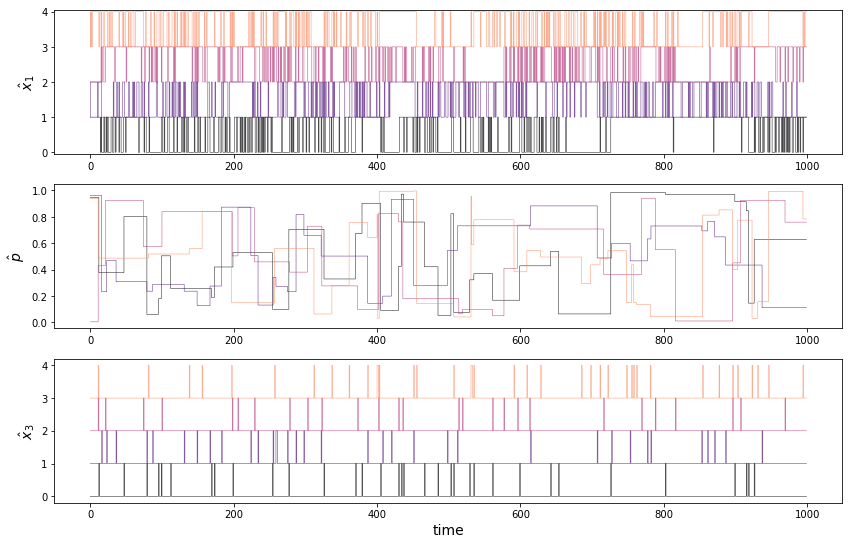

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(fig_width, fig_width/1.6180))
stick = np.zeros_like(p)
stick[:, :, 0] = np.ones((N_time, 1)) * np.arange(N_trials)[np.newaxis, :]
stick[:, :, 2] = np.ones((N_time, 1)) * np.arange(N_trials)[np.newaxis, :]
for i_layer, label in enumerate([r'$\^x_1$', r'$\^p$', r'$\^x_3$']):
    from cycler import cycler
    axs[i_layer].set_prop_cycle(cycler('color', [plt.cm.magma(h) for h in np.linspace(0, 1, N_trials+1)]))
    _ = axs[i_layer].step(time, p[:, :, i_layer]+stick[:, :, i_layer], lw=.5, alpha=.9)
    axs[i_layer].axis('tight')
    axs[i_layer].set_ylabel(label, fontsize=14)
fig.tight_layout()
for i in range(1): axs[i].set_ylim(-.05, N_trials + .05)
axs[-1].set_xlabel('time', fontsize=14);
plt.savefig('/Users/damasse.j-b/ownCloud/ANR-REM/ASPEM_REWARD/plots/VSS_try.pdf', bbox_inches='tight')

## particle filtering - no resampling

In [20]:
np.random.randint(3)

2

In [4]:
i_trial = np.random.randint(N_trials)
print('Sample', i_trial)

Sample 2


In [5]:
N_particles = 1000000
N_particles_show = 100

p_hat = np.zeros((N_time, N_particles, N_layer+1-1))
# init
i_time = 0
p_hat[i_time, :, 0] = 1 # weights
p_hat[i_time, :, 0] /= p_hat[i_time, :, 0].sum()
p_hat[i_time, :, 1] = np.random.rand(N_particles) # bernouilli coeff
p_hat[i_time, :, 2] = np.random.rand(N_particles) < 1/tau # switch

for i_time in time[1:]:
    # prediction following the (known) generative model
    p_hat[i_time, :, 2] = np.random.rand(N_particles) < 1/tau # switch
    p_hat[i_time, :, 1] = (1 - p_hat[i_time, :, 2])*p_hat[i_time-1, :, 1] + p_hat[i_time, :, 2] *  np.random.rand(N_particles)
    # likelihood
    p_hat[i_time, :, 0] = p_hat[i_time-1, :, 0]
    p_hat[i_time, :, 0] *= p_hat[i_time, :, 1]*p[i_time, i_trial, 0] + (1-p_hat[i_time, :, 1])*(1-p[i_time, i_trial, 0])
    # resampling
    p_hat[i_time, :, 0] /= p_hat[i_time, :, 0].sum()

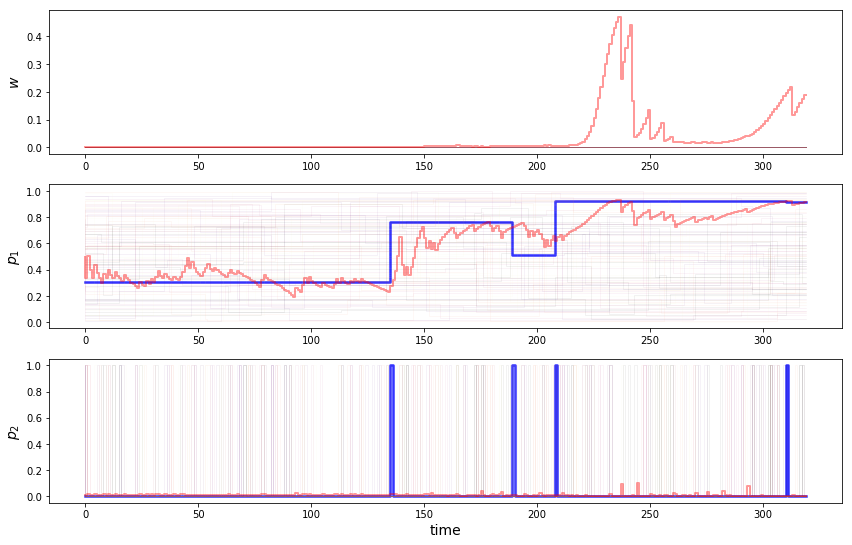

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(fig_width, fig_width/1.6180))
for i_layer, label in enumerate([r'$w$', r'$p_1$', r'$p_2$']):
    from cycler import cycler
    if i_layer > 0: _ = axs[i_layer].step(time, p[:, i_trial, i_layer], c='b', lw=2.5, alpha=.8)
    axs[i_layer].set_prop_cycle(cycler('color', [plt.cm.magma(h) for h in np.linspace(0, 1, N_trials+1)]))
    _ = axs[i_layer].step(time, p_hat[:, :N_particles_show, i_layer], lw=.5, alpha=.1)
    _ = axs[i_layer].step(time, np.sum(p_hat[:, :, i_layer]*p_hat[:, :, 0], axis=1), c='r', lw=2, alpha=.4)
    axs[i_layer].axis('tight')
    axs[i_layer].set_ylabel(label, fontsize=14)
fig.tight_layout()
axs[-1].set_xlabel('time', fontsize=14);

In [7]:
p_hat[0, :, 0], p_hat[-1, :, 0]

(array([  1.00000000e-06,   1.00000000e-06,   1.00000000e-06, ...,
          1.00000000e-06,   1.00000000e-06,   1.00000000e-06]),
 array([  3.36715426e-016,   5.06333236e-172,   1.43845027e-033, ...,
          7.65646681e-039,   4.75210797e-032,   5.82675219e-074]))

## particle filtering - homeostatic resampling

We use some heavy cheating by injecting the true values.

In [8]:
p_hat = np.zeros((N_time, N_particles, N_layer+1-1))
# init
i_time = 0
p_hat[i_time, :, 0] = 1 # weights
p_hat[i_time, :, 0] /= p_hat[i_time, :, 0].sum()
p_hat[i_time, :, 1] = np.random.rand(N_particles) # bernouilli coeff
p_hat[i_time, :, 2] = np.random.rand(N_particles) < 1/tau # switch

for i_time in time[1:]:
    particles = p_hat[i_time-1, :, :].copy()
    # prediction following the (known) generative model
    particles[:, 2] = np.random.rand(N_particles) < 1/tau # switch
    particles[:, 1] = (1 - p_hat[i_time, :, 2])*particles[:, 1] + particles[:, 2] *  np.random.rand(N_particles)
    # likelihood
    particles[:, 0] *= particles[:, 1]*p[i_time, i_trial, 0] + (1.-particles[:, 1])*(1-p[i_time, i_trial, 0])
    # resampling
    particles[:, 0] /= particles[:, 0].sum()
    #print (particles[:, 0], particles[:, 0].sum())
    address = [int(k) for k in np.interp(np.random.rand(N_particles), #np.linspace(0, 1, N_particles, endpoint=False),#+1/2./N_particles,
                                         np.concatenate(([0.], np.cumsum(particles[:, 0]))),
                                         np.linspace(0, 1, N_particles+1, endpoint=False) )] #np.arange(N_particles+1))]
    #print(i_time, np.concatenate(([0.], np.cumsum(p_hat[i_time, :, 0]))), address)
    ## reassign these particles and set their weight to a uniform value
    particles[:, :] = particles[address, :]
    particles[:, 0] /= particles[:, 0].sum()
    p_hat[i_time, :, :] = particles


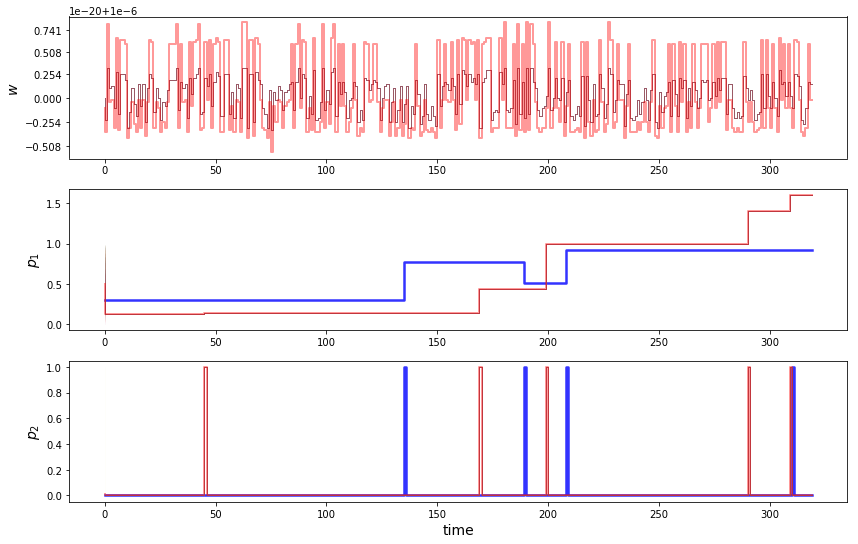

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(fig_width, fig_width/1.6180))
for i_layer, label in enumerate([r'$w$', r'$p_1$', r'$p_2$']):
    from cycler import cycler
    if i_layer > 0: _ = axs[i_layer].step(time, p[:, i_trial, i_layer], c='b', lw=2.5, alpha=.8)
    axs[i_layer].set_prop_cycle(cycler('color', [plt.cm.magma(h) for h in np.linspace(0, 1, N_trials+1)]))
    _ = axs[i_layer].step(time, p_hat[:, :N_particles_show, i_layer], lw=.5, alpha=.1)
    _ = axs[i_layer].step(time, np.sum(p_hat[:, :, i_layer]*p_hat[:, :, 0], axis=1), c='r', lw=2, alpha=.4)
    axs[i_layer].axis('tight')
    axs[i_layer].set_ylabel(label, fontsize=14)
fig.tight_layout()
axs[-1].set_xlabel('time', fontsize=14);



## particle filtering - homeostatic resampling

We use some heavy cheating by injecting the true values.

In [10]:
p_hat = np.zeros((N_time, N_particles, N_layer+1-1))
# init
i_time = 0
p_hat[i_time, :, 0] = 1 # weights
p_hat[i_time, :, 0] /= p_hat[i_time, :, 0].sum()
p_hat[i_time, :, 1] = np.random.rand(N_particles) # bernouilli coeff
p_hat[i_time, :, 2] = np.random.rand(N_particles) < 1/tau # switch

for i_time in time[1:]:
    particles = p_hat[i_time-1, :, :].copy()
    # prediction following the (known) generative model
    particles[:, 2] = np.random.rand(N_particles) < 1/tau # switch
    particles[:, 1] = (1 - p_hat[i_time, :, 2])*particles[:, 1] + particles[:, 2] *  np.random.rand(N_particles)
    # likelihood
    particles[:, 0] *= particles[:, 1]*p[i_time, i_trial, 0] + (1.-particles[:, 1])*(1-p[i_time, i_trial, 0])
    # resampling
    particles[:, 0] /= particles[:, 0].sum()
    #print (particles[:, 0], particles[:, 0].sum())
    address = [int(k) for k in np.interp(np.linspace(0, 1, N_particles, endpoint=False)+1/2./N_particles,
                                         np.concatenate(([0.], np.cumsum(particles[:, 0]))),
                                         np.linspace(0, 1, N_particles+1, endpoint=False) )] #np.arange(N_particles+1))]
    #print(i_time, np.concatenate(([0.], np.cumsum(p_hat[i_time, :, 0]))), address)
    ## reassign these particles and set their weight to a uniform value
    particles[:, :] = particles[address, :]
    particles[:, 0] /= particles[:, 0].sum()
    p_hat[i_time, :, :] = particles


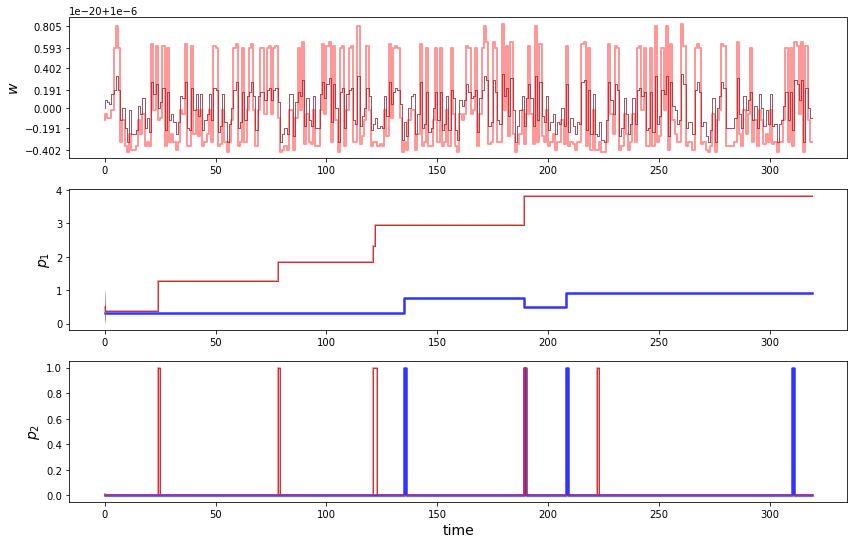

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(fig_width, fig_width/1.6180))
for i_layer, label in enumerate([r'$w$', r'$p_1$', r'$p_2$']):
    from cycler import cycler
    if i_layer > 0: _ = axs[i_layer].step(time, p[:, i_trial, i_layer], c='b', lw=2.5, alpha=.8)
    axs[i_layer].set_prop_cycle(cycler('color', [plt.cm.magma(h) for h in np.linspace(0, 1, N_trials+1)]))
    _ = axs[i_layer].step(time, p_hat[:, :N_particles_show, i_layer], lw=.5, alpha=.1)
    _ = axs[i_layer].step(time, np.sum(p_hat[:, :, i_layer]*p_hat[:, :, 0], axis=1), c='r', lw=2, alpha=.4)
    axs[i_layer].axis('tight')
    axs[i_layer].set_ylabel(label, fontsize=14)
fig.tight_layout()
axs[-1].set_xlabel('time', fontsize=14);

